# Анализ набора данных о посещениях веб-сайта с 2014 по 2016 годы и прогнозирование с помощью модели Prophet.

Загрузка библиотек и данных

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta

dat = pd.read_csv('/content/daily-website-visitors.csv')
dat.head(5)

,Row,Day,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,1,Sunday,1,9/14/2014,"2,146","1,582","1,430",152
1,2,Monday,2,9/15/2014,"3,621","2,528","2,297",231
2,3,Tuesday,3,9/16/2014,"3,698","2,630","2,352",278
3,4,Wednesday,4,9/17/2014,"3,667","2,614","2,327",287
4,5,Thursday,5,9/18/2014,"3,316","2,366","2,130",236


Prophet требует определенных наименований столбцов, где метки времени должны быть в столбце ds, а целевые значения — в столбце y. В качестве целевого значения возьмем столбец Page.Loads. Остальные столбцы удалим.

In [2]:
data = pd.read_csv('/content/daily-website-visitors.csv', parse_dates = True)

data['ds'] = pd.to_datetime(data['Date'])
data = data.rename(columns={'Page.Loads': 'y'})
data['y'] = data['y'].str.replace(',', '').astype(float)

data = data.drop(['Date', 'Row', 'Day', 'Day.Of.Week', 'Unique.Visits', 'First.Time.Visits', 'Returning.Visits'], axis=1)
data.head(5)


,y,ds
0,2146.0,2014-09-14
1,3621.0,2014-09-15
2,3698.0,2014-09-16
3,3667.0,2014-09-17
4,3316.0,2014-09-18


Визуализируем временной ряд.

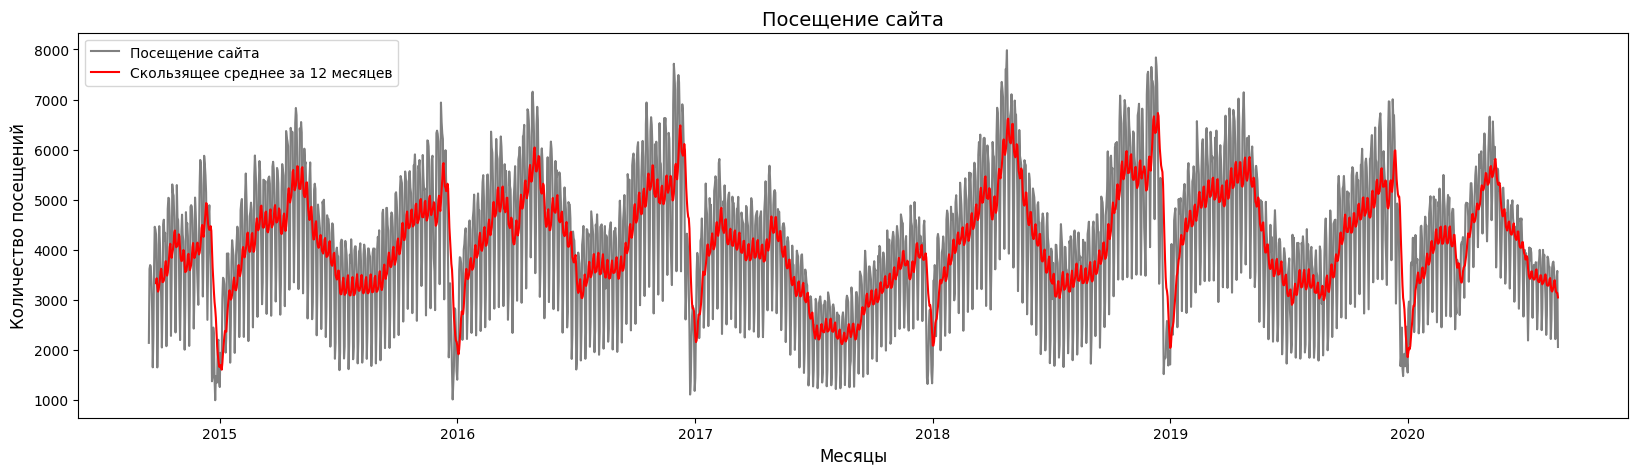

In [3]:
plt.figure(figsize=(20, 5))

data_s = data.set_index('ds')
data_s.head(5)

# зададим кривые
plt.plot(data_s, label = 'Посещение сайта', color = 'gray')
plt.plot(data_s.rolling(window = 12).mean(), label = 'Скользящее среднее за 12 месяцев', color = 'red')
# добавим легенду, ее положение на графике и размер шрифта
plt.legend(title = '', loc = 'upper left', fontsize = 10)
# добавим подписи к осям и заголовки
plt.xlabel('Месяцы', fontsize = 12)
plt.ylabel('Количество посещений', fontsize = 12)
plt.title('Посещение сайта', fontsize = 14)
plt.show()

Разложим временной ряд на компоненты.

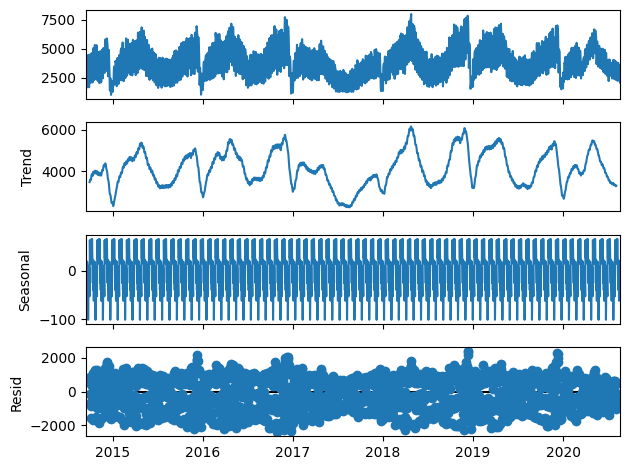

In [4]:
# импортируем функцию seasonal_decompose из statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

# применяем функцию к данным
decompose = seasonal_decompose(data_s, period=30)
decompose.plot()
plt.show()

Проверяем ряд на стационарность по тесту Дики-Фуллера.

In [5]:
# импортируем необходимую функцию
from statsmodels.tsa.stattools import adfuller

# передадим ей столбец с данными и поместим результат в adf_test
adf_test = adfuller(data_s['y'])
# выведем p-value
print('p-value = ' + str(adf_test[1]))

p-value = 0.0004737578257464986


Обучим Prophet с использованием стандартных настроек и оценим качество предсказания.

In [6]:
# разделяем данные на обучающую и тестовую выборки
train = data[data.ds < (data.ds.max() - timedelta(days=30))].copy()
test = data[data.ds >= (data.ds.max() - timedelta(days=30))].copy()

# импортируем модель prophet и метрики оценки качества
import prophet
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

prophet.diagnostics.logging.disable(level=50)
fb = prophet.Prophet()

fb.fit(train)

predictions = fb.make_future_dataframe(periods=len(test), freq='D')
forecast = fb.predict(predictions)

forecast.head(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-09-14,3321.815056,1363.914354,2643.249101,3321.815056,3321.815056,-1283.358783,-1283.358783,-1283.358783,-872.493065,-872.493065,-872.493065,-410.865718,-410.865718,-410.865718,0.0,0.0,0.0,2038.456273
1,2014-09-15,3324.983907,3064.451584,4286.111136,3324.983907,3324.983907,372.291546,372.291546,372.291546,734.249390,734.249390,734.249390,-361.957844,-361.957844,-361.957844,0.0,0.0,0.0,3697.275453
2,2014-09-16,3328.152759,3253.244685,4476.682032,3328.152759,3328.152759,531.827881,531.827881,531.827881,845.430212,845.430212,845.430212,-313.602331,-313.602331,-313.602331,0.0,0.0,0.0,3859.980640
3,2014-09-17,3331.321610,3276.269544,4500.055023,3331.321610,3331.321610,520.806516,520.806516,520.806516,787.155469,787.155469,787.155469,-266.348952,-266.348952,-266.348952,0.0,0.0,0.0,3852.128127
4,2014-09-18,3334.490462,3049.919008,4267.151375,3334.490462,3334.490462,314.040051,314.040051,314.040051,534.752192,534.752192,534.752192,-220.712142,-220.712142,-220.712142,0.0,0.0,0.0,3648.530512


Объеденим тестовые данные и предсказания модели и постороим график.

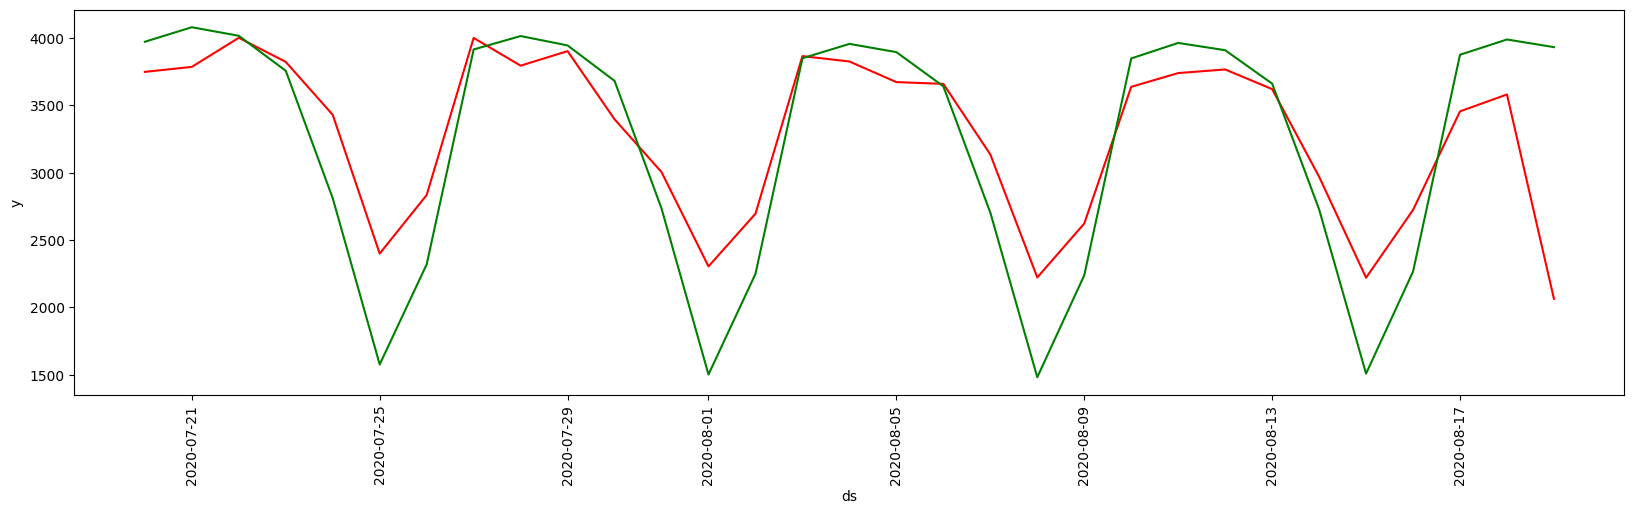

In [7]:
v_fb_df = test.copy()
v_fb_df = v_fb_df.merge(forecast[['ds', 'yhat']], on='ds', how='left')

plt.figure(figsize=(20, 5))
sns.lineplot(data=v_fb_df, x='ds', y='y', color = 'red')
sns.lineplot(data=v_fb_df, x='ds', y='yhat', color = 'green')
plt.xticks(rotation=90)
plt.show()

Расчитаем метрики качества модели.

In [8]:
np.sqrt(mean_squared_error(v_fb_df['y'], v_fb_df['yhat']))

np.float64(514.2903167848739)

In [9]:
mean_absolute_percentage_error(v_fb_df['y'], v_fb_df['yhat'])

0.13679515661319644